In [7]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [14]:
def start_plot():
    global metric_values
    
    metric_values = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values
    print(metric_values)
    with open("metric_values.txt", 'w') as fp:
        for value in metric_values:
            fp.write(f"{value:.5f}\n")
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def plot_values(registration_method):
    global metric_values
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    registration_method.Get
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

In [9]:
preopImage = sitk.ReadImage("preopDrrImage.mha", sitk.sitkFloat32)
intraopImage = sitk.ReadImage("pacient09IntraOpDrr.mha", sitk.sitkFloat32)

intraopImageInverted = sitk.InvertIntensity(intraopImage, maximum=1)
preopImage.GetSize(), intraopImage.GetSize()

((1000, 1000, 1), (1000, 1000))

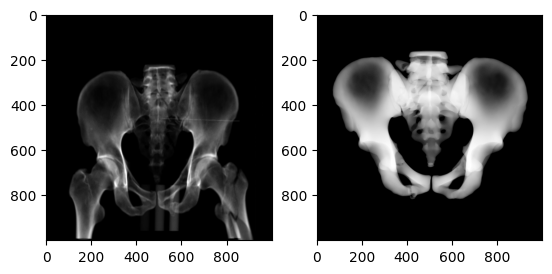

In [10]:
fig2, ax1 = plt.subplots(1, 2)
ax1[0].imshow(sitk.GetArrayViewFromImage(preopImage)[0, ...], cmap="gray")
ax1[1].imshow(sitk.GetArrayViewFromImage(intraopImageInverted), cmap="gray")
plt.show()

Fixed image, spacing: (1.0, 1.0), size: (1000, 1000), direction: (1.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0)
Moving image, spacing: (1.0, 1.0), size: (1000, 1000), direction: (1.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0)


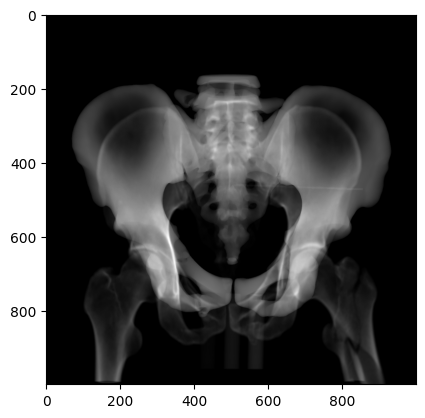

In [11]:
fixedImage = intraopImageInverted
movingImage = preopImage[:, :, 0]
movingImage.SetOrigin(fixedImage.GetOrigin())
movingImage.SetSpacing(fixedImage.GetSpacing())
print(f"Fixed image, spacing: {fixedImage.GetSpacing()}, size: {fixedImage.GetSize()}, direction: {fixedImage.GetDirection()}, origin: {fixedImage.GetOrigin()}")
print(f"Moving image, spacing: {movingImage.GetSpacing()}, size: {movingImage.GetSize()}, direction: {movingImage.GetDirection()}, origin: {movingImage.GetOrigin()}")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImage), cmap="gray", alpha=0.5)
plt.show()

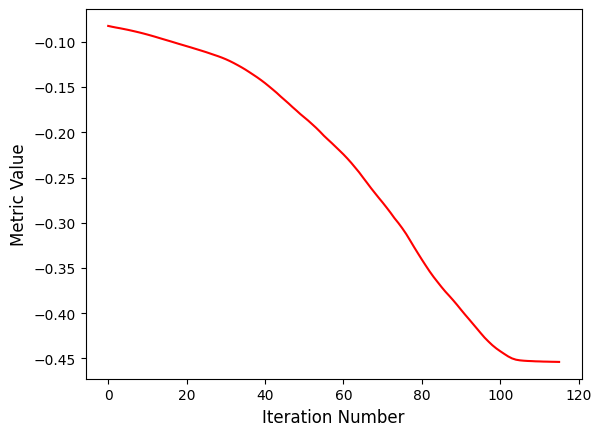

[-0.0823955480839197, -0.0833425623267253, -0.08419284120078624, -0.08496190014110956, -0.08583259424847235, -0.08670220429525569, -0.08765994007855167, -0.08865657775173426, -0.08968798034671147, -0.09078781474391336, -0.09194528930554137, -0.09315746061848246, -0.09440539492577509, -0.09571491107115827, -0.09701575005956942, -0.09829848824553412, -0.09956650077180795, -0.10089601909203832, -0.10222134143001976, -0.10349109327965421, -0.10478304015093255, -0.10604814258777814, -0.10739337218340267, -0.10871977192577803, -0.110059657326456, -0.11142863883299414, -0.11289816208442784, -0.11438790382839505, -0.11584143410354196, -0.1174514647944716, -0.11923235379310329, -0.12120631067116462, -0.12338472008483144, -0.12570492532721672, -0.12812910794930535, -0.13070387205970735, -0.13349150284998573, -0.1363645140186443, -0.13924902225832364, -0.14235066826254905, -0.14563626825713497, -0.14916454626117887, -0.1527741062145483, -0.15646643854355585, -0.1604845651402715, -0.16426480268274

In [17]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage,
                                                     sitk.AffineTransform(2))
registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMattesMutualInformation()
registration.SetOptimizerScalesFromPhysicalShift()
registration.SetOptimizerAsGradientDescent(learningRate=1.0,
                                           numberOfIterations=200,
                                           convergenceMinimumValue=1e-5,
                                           convergenceWindowSize=5)
registration.SetInitialTransform(initialTransform)
registration.SetInterpolator(sitk.sitkLinear)

registration.AddCommand(sitk.sitkStartEvent, start_plot)
registration.AddCommand(sitk.sitkEndEvent, end_plot)
registration.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration))
outTransform = registration.Execute(fixedImage, movingImage)
print(f"Optimizer stop condition: {registration.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {registration.GetOptimizerIteration()}")
print(f" Metric value: {registration.GetMetricValue()}")

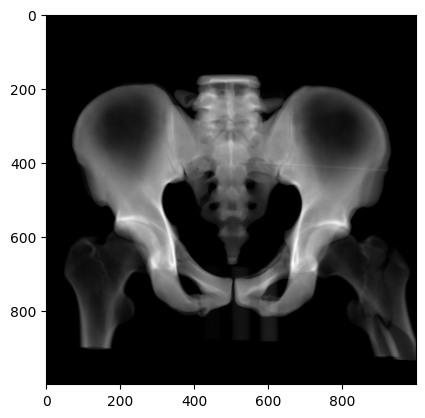

In [18]:
movingImageResampled = sitk.Resample(movingImage, fixedImage, outTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled), cmap="gray", alpha=0.5)
plt.show()

In [76]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
out = elastixImageFilter.Execute()

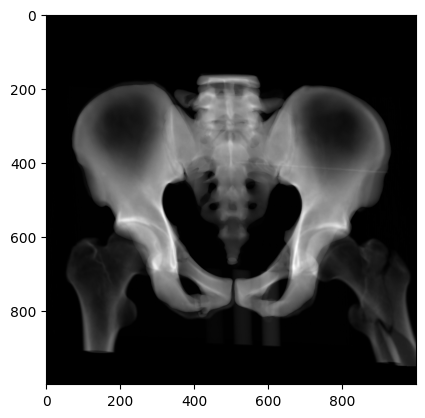

In [77]:
plt.imshow(sitk.GetArrayViewFromImage(out), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray", alpha=0.5)

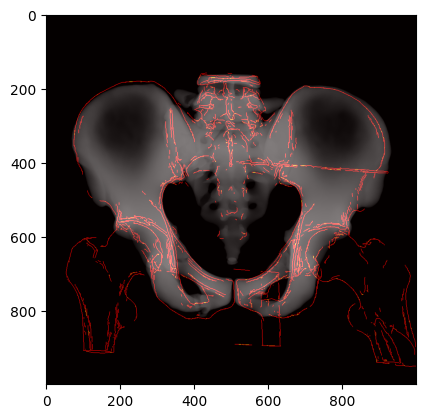

In [96]:
sitkImageEdges = sitk.CannyEdgeDetection(out, lowerThreshold=600, upperThreshold=700)
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(sitkImageEdges), cmap="hot", alpha=0.5)

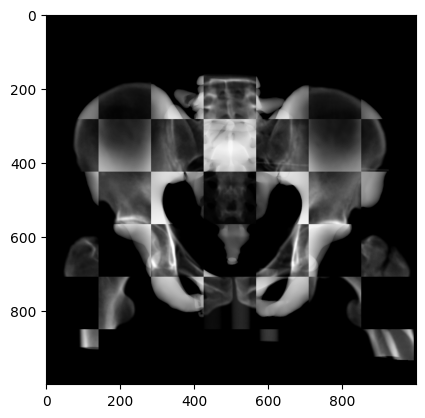

In [25]:
movingImageResampled255 = sitk.Cast(sitk.IntensityWindowing(movingImageResampled, 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
fixedImage255 = sitk.Cast(sitk.IntensityWindowing(sitk.RescaleIntensity(fixedImage, 0, 32767), 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
plt.imshow(sitk.GetArrayViewFromImage(sitk.CheckerBoard(movingImageResampled255, fixedImage255, [7,7])), cmap="gray")
plt.show()

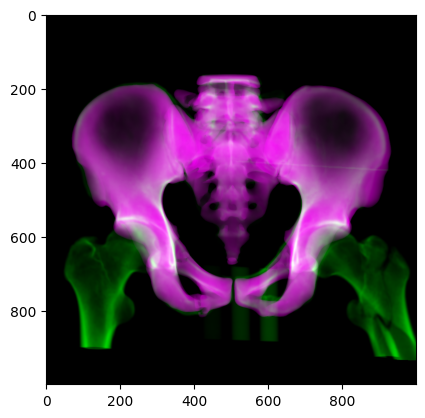

In [20]:
zeros = sitk.Image(movingImageResampled255.GetSize(), movingImageResampled255.GetPixelID())
zeros.CopyInformation(fixedImage255)

composedImage = sitk.Cast(sitk.Compose(fixedImage255, movingImageResampled255, fixedImage255), sitk.sitkVectorUInt8)
plt.imshow(sitk.GetArrayViewFromImage(composedImage))
plt.show()